## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TEXT_START = 45
TEXT_END = -368

In [3]:
def load_sonnet_lines():
    try:
        with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
            lines = iofile.readlines()
    except FileNotFoundError:
        !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
        with open('sonnets.txt', 'r') as iofile:
            lines = iofile.readlines()
    lines = lines[TEXT_START : TEXT_END]
    return lines

In [4]:
lines = load_sonnet_lines()
assert len(lines) == 2616

### Data Preparation

#### Parsing source lines into lowercased sonnets

In [5]:
def parse_sonnets(lines):
    """Parses list of sonnet lines into the list of lowercased sonnet texts"""
    sonnets = []
    sonnet_lines = []
    for line in lines:
        if not line.strip() or line.strip().isupper(): # ignore empty lines and sonnet numeration
            if sonnet_lines:
                sonnets.append(''.join(sonnet_lines))
                sonnet_lines = []
        else:
            line = line.lower().replace('  ', ' ') # lowercase and dealing with duplicate spaces
            sonnet_lines.append(line)
    if sonnet_lines: # Last sonnet
        sonnets.append(''.join(sonnet_lines))
    return sonnets

In [6]:
sonnets = parse_sonnets(lines)
assert len(sonnets) == 154

#### Retrieving all the lines from sonnets

In [10]:
all_sonnet_lines = [line + '\n' for sonnet in sonnets for line in sonnet.split('\n') if line]
len(all_sonnet_lines)

2155

Max line length: 62


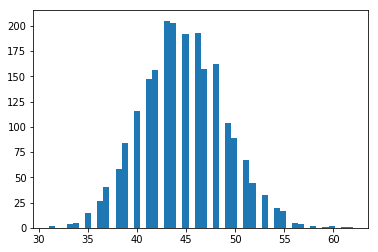

In [12]:
line_lengths = [len(line) for line in all_sonnet_lines]
MAX_LINE_LENGTH = max(line_lengths)
print(f'Max line length: {MAX_LINE_LENGTH}')
plt.hist(line_lengths, bins=50);

#### Generating dataset of all the quatrains

In [13]:
def get_quatrains(sonnets):
    quatrains = []
    for sonnet in sonnets:
        sonnet_lines = list(filter(None, sonnet.split('\n')))
        for i in range(0, len(sonnet_lines), 4):
            quatrains.append('\n'.join(sonnet_lines[i:i + 4]) + '\n')
    return quatrains

In [14]:
quatrains = get_quatrains(sonnets)
len(quatrains)

615

Max quatrain length: 209


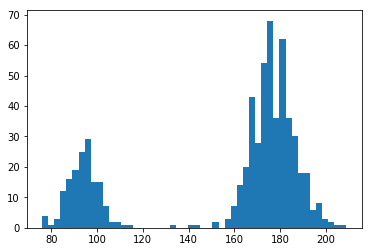

In [16]:
quatrain_lengths = [len(quatrain) for quatrain in quatrains]
MAX_QUATRAIN_LENGTH = max(quatrain_lengths)
print(f'Max quatrain length: {MAX_QUATRAIN_LENGTH}')
plt.hist(quatrain_lengths, bins=50);

#### Preparing dictionaries for char-level tokenization

In [17]:
tokens = sorted({c for line in all_sonnet_lines for c in line})

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [18]:
# dict <index>:<char>
token_to_idx = {c: idx for idx, c in enumerate(tokens)}

# dict <char>:<index>
idx_to_token  = {idx: c for idx, c in enumerate(tokens)}

In [31]:
num_tokens = len(tokens)

In [19]:
len(tokens), len(token_to_idx), len(idx_to_token)

(38, 38, 38)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Utilities

In [22]:
def to_matrix(texts, max_len=None, pad=token_to_idx['\n'], dtype='int32', batch_first=True):
    """Casts a list of texts into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, texts))
    token_ids = np.zeros([len(texts), max_len], dtype) + pad

    for i in range(len(texts)):
        row = [token_to_idx[c] for c in texts[i]]
        token_ids[i, :len(row)] = row
        
    if not batch_first: # convert [batch, time] into [time, batch]
        token_ids = np.transpose(token_ids)

    return token_ids

In [1546]:
# print(''.join(all_sonnet_lines[::750]))
# print(to_matrix(all_sonnet_lines[::750]))

In [27]:
from random import sample

BATCH_SIZE = 32

def get_random_batch(texts, max_len, batch_size=BATCH_SIZE):
    batch = to_matrix(sample(texts, batch_size), max_len=max_len)
    batch = torch.tensor(batch, dtype=torch.int64)
    return batch

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from IPython.display import clear_output

In [246]:
def train_model(model, opt, lr_scheduler, criterion,
                texts, max_len, n_iter=5000, batch_size=BATCH_SIZE, plot=True):
    loss_history = []
    model.train()
    for i in range(n_iter):
        batch = get_random_batch(texts, max_len, batch_size).to(device)

        logit_seq = model(batch)
        loss = criterion(logit_seq[:, :-1].contiguous().view(-1, num_tokens),
                     batch[:, 1:].contiguous().view(-1))
        loss_history.append(loss.data.detach().cpu().numpy())

        loss.backward()
        opt.step()
        opt.zero_grad()
        if lr_scheduler:
            lr_scheduler.step(loss_history[-1])

        if plot and (i+1) % 100 == 0:
            clear_output(True)
            plt.plot(loss_history, label='loss')
            plt.legend()
            plt.show()

In [247]:
def eval_model(model, criterion, texts, max_len):
    model.eval()
    with torch.no_grad():
        data = to_matrix(texts, max_len=max_len)
        data = torch.tensor(data, dtype=torch.int64).to(device)
        logit_seq = model(data).to(device)
        loss = criterion(logit_seq[:, :-1].contiguous().view(-1, num_tokens),
                     data[:, 1:].contiguous().view(-1))
        return loss.item()

In [248]:
def get_optimizer(model, lr=5e-3):
    trainable_params = [param for param in model.parameters() if param.requires_grad]
    opt = torch.optim.Adam(trainable_params, lr=lr)
    return opt

In [505]:
def generate_sample(model, seed_phrase, max_length, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    if hasattr(model, 'rnn'):
        rnn = model.rnn
        hid_state = torch.zeros(rnn.num_layers, 1, rnn.hidden_size).to(device)
    elif hasattr(model, 'lstm'):
        rnn = model.lstm
        hid_state = (torch.zeros(rnn.num_layers, 1, rnn.hidden_size).to(device),
                    torch.zeros(rnn.num_layers, 1, rnn.hidden_size).to(device))
    else:
        raise NotImplementedError
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    #feed the seed phrase, if any
    if len(seed_phrase) > 1:
        out, hid_state = model(x_sequence[..., :-1], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = model(x_sequence[..., -1:], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).detach().cpu().numpy().squeeze()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.detach().cpu().numpy().squeeze()])

In [30]:
GPU_INDEX = '1'
device = torch.device(f'cuda:{GPU_INDEX}') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

#### RNN
Such a simple model we will train on lines, not quatrains

In [244]:
class CharRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=num_tokens, rnn_num_units=165):
        super(self.__class__, self).__init__()
        
        if emb_size:
            self.emb = nn.Embedding(num_tokens, emb_size)
        else:
            # One-hot encoding by freezed Embedding layer
            self.emb = nn.Embedding(num_tokens, num_tokens)
            self.emb.weight.data = torch.eye(num_tokens)
            self.emb.weight.requires_grad = False
            emb_size = num_tokens
        
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h_seq, hidden = self.rnn(self.emb(x), hidden)
            next_logits = self.hid_to_logits(h_seq)
            return next_logits, hidden
        else:
            h_seq, _ = self.rnn(self.emb(x))
            next_logits = self.hid_to_logits(h_seq)
            return next_logits

In [250]:
char_rnn = CharRNN().to(device)
opt = get_optimizer(char_rnn)
lr_scheduler = StepLR(opt, 300, 0.1)
criterion = nn.CrossEntropyLoss()

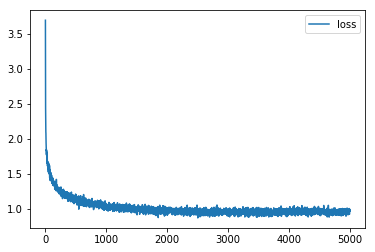

In [251]:
train_model(char_rnn, opt, lr_scheduler, criterion, all_sonnet_lines, MAX_LINE_LENGTH)

In [252]:
eval_model(char_rnn, criterion, all_sonnet_lines, MAX_LINE_LENGTH)

0.9573969841003418

In [337]:
generate_sample(char_rnn, ' from', MAX_LINE_LENGTH)

' from her praise, have bright pleasure of old stone, blessed, '

In [360]:
generate_sample(char_rnn, ' the', MAX_LINE_LENGTH, 1.75)

" they mays. than'w anon? for it is much needs\n\n\n\n\n and;\n\n\n\n\n\n\n"

In [368]:
generate_sample(char_rnn, ' not great, not terrible', MAX_LINE_LENGTH)

' not great, not terrible or poor on that yourselt, than their '

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [494]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=num_tokens, num_units=176, num_layers=2, dropout=0):
        super(self.__class__, self).__init__()
        
        if emb_size:
            self.emb = nn.Embedding(num_tokens, emb_size)
        else:
            # One-hot encoding by freezed Embedding layer
            self.emb = nn.Embedding(num_tokens, num_tokens)
            self.emb.weight.data = torch.eye(num_tokens)
            self.emb.weight.requires_grad = False
            emb_size = num_tokens
        
        self.lstm = nn.LSTM(emb_size, num_units, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.hid_to_logits = nn.Linear(num_units, num_tokens)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h_seq, hidden = self.lstm(self.emb(x), hidden)
            next_logits = self.hid_to_logits(h_seq)
            return next_logits, hidden
        else:
            h_seq, _ = self.lstm(self.emb(x))
            next_logits = self.hid_to_logits(h_seq)
            return next_logits

In [1297]:
char_lstm = CharLSTM(num_units=176, num_layers=2, dropout=0).to(device)
opt = get_optimizer(char_lstm)
lr_scheduler = StepLR(opt, 300, 0.1)
criterion = nn.CrossEntropyLoss()

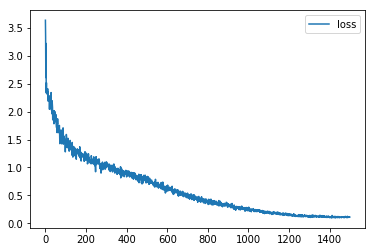

In [1299]:
train_model(char_lstm, opt, lr_scheduler, criterion, quatrains, MAX_QUATRAIN_LENGTH, n_iter=1500)

In [1300]:
eval_model(char_lstm, criterion, quatrains, MAX_QUATRAIN_LENGTH)

0.10981304943561554

In [1301]:
print(generate_sample(char_lstm, ' from', MAX_QUATRAIN_LENGTH, 0.01).strip())

from fairest creatures we desire increase,
 that thereby beauty's rose might never die,
 but as the riper should by time decease,
 his tender heir might bear his memory:


#### Let's find the most similar samples from the train set
We will use MinHash-based locality-sensitive hashing (LSH) to find training examples that share bigrams with model output

In [936]:
from datasketch import MinHash, MinHashLSH
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.util import ngrams
import re
from IPython.display import display, Markdown
from itertools import chain

In [865]:
stop_words = set(stopwords.words('english')) 

In [1074]:
def make_bigrams(text, remove_stop_words=True):
    words = [word for word in re.findall(r"[\w']+", text)
             if word not in stop_words or not remove_stop_words]
    return list(ngrams(words, 2))

def get_bytes(bigram):
    return '$$'.join(bigram).encode('utf8')

def get_jaccard_similarity(collection1, collection2):
    collection1 = set(collection1)
    collection2 = set(collection2)
    return len(collection1 & collection2) / len(collection1 | collection2)

def to_markdown(text):
    return text.strip().replace('\n', '<br>')

def highlight_words(text, words):
    # There's known bug in Jupyter with rendering single-character bold modifiers, e.g.
    # "**a** **b**". We'll be using a hack with additional "</t>" sequence
    return to_markdown(re.sub(r'\b(' + '|'.join(words) + r')\b', r'**\1</t>**', text))

In [1025]:
lsh = MinHashLSH(threshold=0.03, num_perm=128)
for i, quatrain in enumerate(quatrains):
    mh = MinHash(num_perm=128)
    for bigram in make_bigrams(quatrain):
        mh.update(get_bytes(bigram))
    lsh.insert(i, mh)

In [1026]:
def find_similar_documents(query, lsh=lsh):
    query_hash = MinHash(num_perm=128)
    for bigram in make_bigrams(query):
        query_hash.update(get_bytes(bigram))
    return lsh.query(query_hash)

In [1114]:
def show_similar_quatrains(model_output, lsh=lsh):
    report = f'**Model output:**<br>{to_markdown(model_output)}<br><br>'
    similar_ids = find_similar_documents(model_output)
    if len(similar_ids) > 0:
        report += f'Similar quatrains from the train set:<br>'
    model_output_bigrams = set(make_bigrams(model_output, remove_stop_words=False))
    for quatrain_id in similar_ids:
        quatrain = quatrains[quatrain_id]
        quatrain_bigrams = set(make_bigrams(quatrain, remove_stop_words=False))
        score = get_jaccard_similarity(model_output_bigrams, quatrain_bigrams)
        if score < 0.03:
            continue # Ignore false positives
        report += f'<br>Jaccard similarity = {score:.3f}:<br>'
        common_bigrams = model_output_bigrams & quatrain_bigrams
        common_words = set(chain(*common_bigrams))
        quatrain = highlight_words(quatrain, common_words)
        report += quatrain + '<br>'
    display(Markdown(report))

In [1304]:
show_similar_quatrains(generate_sample(char_lstm, ' from', MAX_QUATRAIN_LENGTH, 0.1))

**Model output:**<br>from fairest creatures we desire increase,<br> that thereby beauty's rose might never die,<br> but as the riper should by time decease,<br> his tender heir might bear his memory:<br><br>Similar quatrains from the train set:<br><br>Jaccard similarity = 1.000:<br>**from</t>** **fairest</t>** **creatures</t>** **we</t>** **desire</t>** **increase</t>**,<br> **that</t>** **thereby</t>** **beauty's</t>** **rose</t>** **might</t>** **never</t>** **die</t>**,<br> **but</t>** **as</t>** **the</t>** **riper</t>** **should</t>** **by</t>** **time</t>** **decease</t>**,<br> **his</t>** **tender</t>** **heir</t>** **might</t>** **bear</t>** **his</t>** **memory</t>**:<br>

In [1545]:
show_similar_quatrains(generate_sample(char_lstm, ' love is', MAX_QUATRAIN_LENGTH, 0.5))

**Model output:**<br>love is my sin, and thy dear love to score;<br> therefore with infection should he live,<br> and with his quick for fitures appents.<br><br>Similar quatrains from the train set:<br><br>Jaccard similarity = 0.100:<br>that poor retention could not so much hold,<br> nor need i tallies **thy</t>** **dear</t>** **love</t>** **to</t>** **score</t>**;<br> **therefore</t>** **to</t>** give them from me was i bold,<br> **to</t>** trust those tables that receive thee more:<br><br>Jaccard similarity = 0.179:<br>ah! wherefore **with</t>** **infection</t>** **should</t>** **he</t>** **live</t>**,<br> **and</t>** **with</t>** **his</t>** presence grace impiety,<br> that sin by him advantage **should</t>** achieve,<br> **and</t>** lace itself **with</t>** **his</t>** society?<br><br>Jaccard similarity = 0.125:<br>**love</t>** **is</t>** **my</t>** **sin</t>**, **and</t>** **thy</t>** **dear</t>** virtue hate,<br> hate of **my</t>** **sin</t>**, grounded on sinful loving:<br> o! but with mine compare thou thine own state,<br> **and</t>** thou shalt find it merits not reproving;<br>

In [1541]:
show_similar_quatrains(generate_sample(char_lstm, ' from', MAX_QUATRAIN_LENGTH, 1))

**Model output:**<br>from far i fresh repair in my storm<br> to yet receives reproving days,<br>  there take thou art torcounty, and dost<br> all this golden to come so others was me.<br><br>Similar quatrains from the train set:<br>

In [1436]:
show_similar_quatrains(generate_sample(char_lstm, ' from', MAX_QUATRAIN_LENGTH, 2))

**Model output:**<br>from (tied rhymedh's lies to theee<br>  teals dear heit<br> break right, when how thy qutel,<br> that suxpest seaso, lev one dearth, or var'd thy<br> against kisomy praise wost know---grest'red:<br><br>

In [1451]:
show_similar_quatrains(generate_sample(char_lstm, ' from', MAX_QUATRAIN_LENGTH, 5))

**Model output:**<br>from on kindiescomengjain<br> sworvyqthy brued dublyysta)arkgo,;<br> weltingue, y?out) daluatt!?<br> nw'r!iw:<br> i hishgodly-die<br>  ranfoaa)--wad;<br>  bewordfwa'g what is.h-k sucerx?ase.ds?!z:<br><br><br>-rxaa<br> t un janour'd like,<br><br>

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [1548]:
model_path = 'char_lstm.pth'
torch.save(char_lstm.state_dict(), model_path)

In [1549]:
model = CharLSTM(num_units=176, num_layers=2, dropout=0).to(device)
model.load_state_dict(torch.load(model_path))
model.to(device)

CharLSTM(
  (emb): Embedding(38, 38)
  (lstm): LSTM(38, 176, num_layers=2, batch_first=True)
  (hid_to_logits): Linear(in_features=176, out_features=38, bias=True)
)

In [1552]:
print(generate_sample(model, ' from', MAX_QUATRAIN_LENGTH, 0.1).strip())

from fairest creatures we desire increase,
 that thereby beauty's rose might never die,
 but as the riper should by time decease,
 his tender heir might bear his memory:


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)